In [1]:
#Trafic Accident Analysis - US dataq from February 2016 - March 2023


In [ ]:
#**1 Settig up the environment
import pyspark
import findspark
findspark.init()
import pyspark
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import os
import os
print("JAVA_HOME:", os.environ.get("JAVA_HOME"))
print("SPARK_HOME:", os.environ.get("SPARK_HOME"))
print("PATH:", os.environ.get("PATH"))


In [59]:
#lodaing the dataset and showing up the first two rows
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import pyspark.sql.types as P
import pyspark.sql.functions as F
spark=pyspark.sql.SparkSession.builder.master('local[*]').appName('US-Accident-Analysis-exe').getOrCreate()
File_path=(r"C:\Users\HP\Downloads\archive (5)\US_Accidents_March23.csv")
df_spark=spark.read.csv(File_path, inferSchema=True, header=True)
df_spark.show(2)

+---+-------+--------+-------------------+-------------------+-----------------+----------+-------+-------+------------+--------------------+--------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat| Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|  Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_E

#Exploring the Dataset and Preprocessing


In [4]:
print('Data overview')
df_spark.printSchema()
print('Columns Overview')
pd.DataFrame(df_spark.dtypes, columns=['Columen Name','Data Type'])

Data overview
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable 

,Columen Name,Data Type
0,ID,string
1,Source,string
2,Severity,int
3,Start_Time,timestamp
4,End_Time,timestamp
5,Start_Lat,double
6,Start_Lng,double
7,End_Lat,double
8,End_Lng,double
9,Distance(mi),double


In [5]:
from pyspark.sql.functions import col, sum as _sum

# Calculate the number of nulls in each column
null_counts = df_spark.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns])

# Convert the result to a pandas DataFrame for sorting and easier display
null_counts_df = null_counts.toPandas().transpose().reset_index()
null_counts_df.columns = ['column_name', 'null_count']

# Sort the null counts in descending order
sorted_null_counts = null_counts_df.sort_values(by='null_count', ascending=False)

# Display the result
print(sorted_null_counts)


              column_name  null_count
7                 End_Lat     3402762
8                 End_Lng     3402762
27      Precipitation(in)     2203586
21          Wind_Chill(F)     1999019
26        Wind_Speed(mph)      571233
24         Visibility(mi)      177098
25         Wind_Direction      175206
22            Humidity(%)      174144
28      Weather_Condition      173459
20         Temperature(F)      163853
23           Pressure(in)      140679
19      Weather_Timestamp      120228
44      Nautical_Twilight       23246
43         Civil_Twilight       23246
42         Sunrise_Sunset       23246
45  Astronomical_Twilight       23246
18           Airport_Code       22635
11                 Street       10869
17               Timezone        7808
15                Zipcode        1915
12                   City         253
10            Description           5
40         Traffic_Signal           0
36             Roundabout           0
37                Station           0
38          

In [6]:
#Find the percentage of the missing values which will help us to identify which 
#columns have the most missing data relative to the dataset's size.

# Get the total number of rows
total_rows = df_spark.count()

# Calculate the percentage of null values for each column
null_percentage = df_spark.select([( _sum(col(c).isNull().cast("int")) / total_rows * 100 ).alias(c) for c in df_spark.columns])

# Convert to pandas DataFrame for easier viewing and sorting
null_percentage_df = null_percentage.toPandas().transpose().reset_index()
null_percentage_df.columns = ['column_name', 'missing_percentage']

# Sort by the highest percentage of missing values
sorted_null_percentage_df = null_percentage_df.sort_values(by='missing_percentage', ascending=False)

print(sorted_null_percentage_df)


              column_name  missing_percentage
7                 End_Lat           44.029355
8                 End_Lng           44.029355
27      Precipitation(in)           28.512858
21          Wind_Chill(F)           25.865904
26        Wind_Speed(mph)            7.391355
24         Visibility(mi)            2.291524
25         Wind_Direction            2.267043
22            Humidity(%)            2.253301
28      Weather_Condition            2.244438
20         Temperature(F)            2.120143
23           Pressure(in)            1.820288
19      Weather_Timestamp            1.555666
44      Nautical_Twilight            0.300787
43         Civil_Twilight            0.300787
42         Sunrise_Sunset            0.300787
45  Astronomical_Twilight            0.300787
18           Airport_Code            0.292881
11                 Street            0.140637
17               Timezone            0.101030
15                Zipcode            0.024779
12                   City         

In [7]:
#Handling the null values based on the above statistics on the 

In [8]:
#Interpretation of Null Values
##High Null Counts:
#1.End_Lat and End_Lng: These columns have the highest number of null values (3,402,762). 
#2.Precipitation(in), Wind_Chill(F), Wind_Speed(mph), Humidity(%), Temperature(F), etc.: 
##Low or No Null Counts:
#Columns like ID, Source, Severity, Start_Time, Start_Lat, Start_Lng, 
##others have no null values, which is good because these are critical for our analysis.




In [9]:
#Steps to Handle Null Values
#The group has descided to handle the missing vaules with the followng strategies 


In [ ]:
#1. Drop Columns with Excessive Null Values
df_spark = df_spark.drop("End_Lat", "End_Lng")


In [ ]:
#2. Fill Null Values with Appropriate Values
from pyspark.sql.functions import mean

# Calculate the mean for each column individually
mean_precipitation = df_spark.agg(mean('Precipitation(in)').alias('mean')).collect()[0]['mean']
mean_wind_chill = df_spark.agg(mean('Wind_Chill(F)').alias('mean')).collect()[0]['mean']
mean_wind_speed = df_spark.agg(mean('Wind_Speed(mph)').alias('mean')).collect()[0]['mean']
mean_visibility = df_spark.agg(mean('Visibility(mi)').alias('mean')).collect()[0]['mean']
mean_temperature = df_spark.agg(mean('Temperature(F)').alias('mean')).collect()[0]['mean']
mean_pressure = df_spark.agg(mean('Pressure(in)').alias('mean')).collect()[0]['mean']
mean_humidity = df_spark.agg(mean('Humidity(%)').alias('mean')).collect()[0]['mean']


# Check for None values in the means
print("Mean Values:")
print(f"Precipitation: {mean_precipitation}")
print(f"Wind Chill: {mean_wind_chill}")
print(f"Wind Speed: {mean_wind_speed}")
print(f"Visibility: {mean_visibility}")
print(f"Temperature: {mean_temperature}")
print(f"Pressure: {mean_pressure}")
print(f"Humidity: {mean_humidity}")
# Fill null values only where the mean is not None
df_spark = df_spark.fillna({
    'Precipitation(in)': mean_precipitation if mean_precipitation is not None else 0,
    'Wind_Chill(F)': mean_wind_chill if mean_wind_chill is not None else 0,
    'Wind_Speed(mph)': mean_wind_speed if mean_wind_speed is not None else 0,
    'Visibility(mi)': mean_visibility if mean_visibility is not None else 0,
    'Temperature(F)': mean_temperature if mean_temperature is not None else 0,
    'Pressure(in)': mean_pressure if mean_pressure is not None else 0,
    'Humidity(%)': mean_humidity if mean_humidity is not None else 0,
    })







In [ ]:

#3. Weather_Timestamp - Method: Forward/Backward Fill
#Reason: Since timestamps are sequential, we can use the value from the previous or next record to fill in the missing value.

#4. Nautical_Twilight, Civil_Twilight, Sunrise_Sunset, Astronomical_Twilight
#Method: Forward/Backward Fill or Imputation based on Time of Day
# Reason: These features are related to the time of day and can often be inferred from 
#adjacent rows or calculated based on the time of day in the Start_Time column.

#5. Airport_Code - Method: Fill with Most Frequent Value
#Reason: If Airport_Code is missing, it's likely that a common airport code can be inferred 
#based on nearby rows (e.g., based on location). Filling with the most frequent value might 
#be reasonable, or filling based on the nearest known airport.  

#6. Street- Method: Forward Fill or Leave Null
#Reason: Streets may not always be necessary for analysis, and filling with previous/next values could
#be appropriate if street names are repetitive or follow a pattern. Otherwise, we can leave them as null.

#7. Timezone - Method: Fill Based on Geographical Information
#Reason: Timezones can be inferred based on the State or City columns. Use a mapping of states to timezones. 


#8.  Zipcode- Method: Fill Based on Geographical Information or leave it 
#Reason: Zipcodes can be filled using the City or County columns if a reliable mapping is available
#In our case we can fill it or leave null since it is less importance for our anaysis

#9. City - Method: Fill with Most Frequent Value or Geographical Inference
#Reason: The city can often be inferred from the Zipcode, County, or State. Alternatively, you could fill it with the most common city within the state or county.



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when

# 3. Weather_Timestamp - Forward/Backward Fill using Window functions
df_spark = df_spark.withColumn(
    "Weather_Timestamp", 
    F.last("Weather_Timestamp", True).over(Window.orderBy("Start_Time"))
)

# 4. Twilight Columns - Forward/Backward Fill using Window functions
twilight_columns = ['Nautical_Twilight', 'Civil_Twilight', 'Sunrise_Sunset', 'Astronomical_Twilight']
for twilight_col in twilight_columns:
    df_spark = df_spark.withColumn(
        twilight_col, 
        F.last(twilight_col, True).over(Window.orderBy("Start_Time"))
    )

# 5. Airport_Code - Fill with Most Frequent Value
most_common_airport = df_spark.groupBy("Airport_Code").count().orderBy(F.desc("count")).first().Airport_Code
df_spark = df_spark.fillna({'Airport_Code': most_common_airport})

# 6. Street - Forward/Backward Fill using Window functions
df_spark = df_spark.withColumn(
    "Street", 
    F.last("Street", True).over(Window.orderBy("Start_Time"))
)

# 7. Wind_Direction - Fill with the most frequent Wind Direction
most_common_wind_direction = df_spark.groupBy("Wind_Direction").count().orderBy(F.desc("count")).first().Wind_Direction
df_spark = df_spark.withColumn("Wind_Direction", when(col("Wind_Direction").isNull(), most_common_wind_direction).otherwise(col("Wind_Direction")))

# 8. Zipcode - Forward/Backward Fill using Window functions
df_spark = df_spark.withColumn(
    "Zipcode", 
    F.last("Zipcode", True).over(Window.orderBy("Start_Time"))
)

# 9. City - Fill with Most Frequent Value
most_common_city = df_spark.groupBy("City").count().orderBy(F.desc("count")).first().City
df_spark = df_spark.fillna({'City': most_common_city})

# 10. Weather_Condition - Fill with Most Frequent Value
most_common_weather_condition = df_spark.groupBy("Weather_Condition").count().orderBy(F.desc("count")).first().Weather_Condition
df_spark = df_spark.withColumn("Weather_Condition", when(col("Weather_Condition").isNull(), most_common_weather_condition).otherwise(col("Weather_Condition")))


In [ ]:
# 7. Timezone - Fill Based on Geographical Information
timezone_mapping = {
    'AL': 'CST',  # Alabama
    'AK': 'AKST',  # Alaska
    'AZ': 'MST',  # Arizona
    'AR': 'CST',  # Arkansas
    'CA': 'PST',  # California
    'CO': 'MST',  # Colorado
    'CT': 'EST',  # Connecticut
    'DE': 'EST',  # Delaware
    'FL': 'EST',  # Florida (Eastern Time, except for the western part which is CST)
    'GA': 'EST',  # Georgia
    'HI': 'HST',  # Hawaii
    'ID': 'MST/PST',  # Idaho (MST for the majority, PST for the northern part)
    'IL': 'CST',  # Illinois
    'IN': 'EST',  # Indiana (some parts use CST)
    'IA': 'CST',  # Iowa
    'KS': 'CST/MST',  # Kansas (CST for the majority, MST for the western part)
    'KY': 'EST/CST',  # Kentucky (EST for the majority, CST for the western part)
    'LA': 'CST',  # Louisiana
    'ME': 'EST',  # Maine
    'MD': 'EST',  # Maryland
    'MA': 'EST',  # Massachusetts
    'MI': 'EST/CST',  # Michigan (EST for the majority, CST for some western parts)
    'MN': 'CST',  # Minnesota
    'MS': 'CST',  # Mississippi
    'MO': 'CST',  # Missouri
    'MT': 'MST',  # Montana
    'NE': 'CST/MST',  # Nebraska (CST for the majority, MST for the western part)
    'NV': 'PST',  # Nevada
    'NH': 'EST',  # New Hampshire
    'NJ': 'EST',  # New Jersey
    'NM': 'MST',  # New Mexico
    'NY': 'EST',  # New York
    'NC': 'EST',  # North Carolina
    'ND': 'CST/MST',  # North Dakota (CST for the majority, MST for the southwestern part)
    'OH': 'EST',  # Ohio
    'OK': 'CST',  # Oklahoma
    'OR': 'PST/MST',  # Oregon (PST for the majority, MST for the eastern part)
    'PA': 'EST',  # Pennsylvania
    'RI': 'EST',  # Rhode Island
    'SC': 'EST',  # South Carolina
    'SD': 'CST/MST',  # South Dakota (CST for the eastern part, MST for the western part)
    'TN': 'CST/EST',  # Tennessee (CST for the western part, EST for the eastern part)
    'TX': 'CST/MST',  # Texas (CST for the majority, MST for the western part)
    'UT': 'MST',  # Utah
    'VT': 'EST',  # Vermont
    'VA': 'EST',  # Virginia
    'WA': 'PST',  # Washington
    'WV': 'EST',  # West Virginia
    'WI': 'CST',  # Wisconsin
    'WY': 'MST',  # Wyoming
    'DC': 'EST'   # Washington, D.C.
}

df_spark = df_spark.withColumn(
    "Timezone", 
    F.coalesce(df_spark["Timezone"], F.create_map([F.lit(x) for x in sum(timezone_mapping.items(), ())])[df_spark['State']])
)

In [ ]:
from pyspark.sql.functions import col, sum as _sum

# Get the total number of rows
total_rows = df_spark.count()

# Calculate the percentage of null values for each column
null_percentage = df_spark.select([( _sum(col(c).isNull().cast("int")) / total_rows * 100 ).alias(c) for c in df_spark.columns])

# Convert to pandas DataFrame for easier viewing and sorting
null_percentage_df = null_percentage.toPandas().transpose().reset_index()
null_percentage_df.columns = ['column_name', 'missing_percentage']

# Sort by the highest percentage of missing values
sorted_null_percentage_df = null_percentage_df.sort_values(by='missing_percentage', ascending=False)

print(sorted_null_percentage_df)

In [ ]:
#Data Type Conversion
#Ensure that columns are in the correct data type:

In [ ]:
from pyspark.sql.functions import to_date, unix_timestamp

# Convert time columns to timestamp
df_spark = df_spark.withColumn("Start_Time", to_date("Start_Time", "yyyy-MM-dd HH:mm:ss"))
df_spark = df_spark.withColumn("End_Time", to_date("End_Time", "yyyy-MM-dd HH:mm:ss"))

# Convert categorical columns to string type if necessary
df_spark = df_spark.withColumn("Weather_Condition", col("Weather_Condition").cast("string"))


In [ ]:
#Explore if there is any outlier exist in our dataset
#IQR (Interquartile Range) Method is used: The IQR method defines outliers as data points that lie beyond 1.5 
#times the IQR above the third quartile or below the first quartile.
from pyspark.sql.functions import expr

def iqr_detection(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    q1, q3 = quantiles[0], quantiles[1]
    
    # Calculate IQR
    iqr = q3 - q1
    
    # Define outlier boundaries
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter outliers
    df_outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    
    return df_outliers
                     


outliers_Start_Lat = iqr_detection(df_spark, "Start_Lat")
outliers_Start_Lng = iqr_detection(df_spark, "Start_Lng")
outliers_Distance = iqr_detection(df_spark, "Distance(mi)")
outliers_Wind_Chill = iqr_detection(df_spark, "Wind_Chill(F)")
outliers_Humidity = iqr_detection(df_spark, "Humidity(%)")
outliers_Pressure = iqr_detection(df_spark, "Pressure(in)")
outliers_Visibility = iqr_detection(df_spark, "Visibility(mi)")
outliers_wind_speed = iqr_detection(df_spark, "Wind_Speed(mph)")
outliers_Precipitation = iqr_detection(df_spark, "Precipitation(in)")
outliers_Severity = iqr_detection(df_spark, "Severity")



In [ ]:
from pyspark.sql.functions import col

# Function to get the count of outliers
def count_outliers(df, column):
    outliers_df = iqr_detection(df, column)
    count = outliers_df.count()
    return count

# Calculate the count of outliers for each feature
outlier_counts = {
    "Start_Lat": count_outliers(df_spark, "Start_Lat"),
    "Start_Lng": count_outliers(df_spark, "Start_Lng"),
    "Distance(mi)": count_outliers(df_spark, "Distance(mi)"),
    "Wind_Chill(F)": count_outliers(df_spark, "Wind_Chill(F)"),
    "Humidity(%)": count_outliers(df_spark, "Humidity(%)"),
    "Pressure(in)": count_outliers(df_spark, "Pressure(in)"),
    "Visibility(mi)": count_outliers(df_spark, "Visibility(mi)"),
    "Wind_Speed(mph)": count_outliers(df_spark, "Wind_Speed(mph)"),
    "Precipitation(in)": count_outliers(df_spark, "Precipitation(in)"),
    "Severity": count_outliers(df_spark, "Severity")
}

# Convert to a DataFrame for better presentation
#outlier_counts_df = spark.createDataFrame(
   # [(k, v) for k, v in outlier_counts.items()],
    #["Feature", "Outlier Count"]
#)

# Show the DataFrame
outlier_counts


In [ ]:
# From the above result we can easly observe that fetures like Distance(mi)', 'Wind_Chill(F)',
#'Pressure(in)', 'Visibility(mi)','Wind_Speed(mph)', 'Precipitation(in)', 'Severity'. 
#Our concern is how the severity has the outlier? severity will assume the values ['Low', 'Medium', 'High'] with 1,2,3 
# We will use a count method how the values are destributed 
#have considareble count of outliers that need to be handle carefully. However numerical values like
#Start_Lat, Start_Lng and Humidity have no outliers which is good for us 


In [ ]:
# Count the occurrences of each Severity level
severity_counts = df_spark.groupBy("Severity").count().orderBy("count", ascending=False)
severity_counts.show()

# Check for any unexpected values outside the range of 1, 2, 3
unexpected_severity = df_spark.filter(~F.col("Severity").isin([1, 2, 3]))
unexpected_severity_count = unexpected_severity.count()

print(f"Count of unexpected Severity values: {unexpected_severity_count}")
#if unexpected_severity_count > 0:
    #unexpected_severity.show()


In [ ]:
# Let us handle the outliers separately 
#we have to use different techniques for handling the outliers the easiest method is to remove 
#them from the dataset. However if we continue removing the dataset for each features separately the 
# dataset will be affected in sise hugely. Therefore we opted to replace them with central tendency 
# measurments like mean, meadian and mode




In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, lit

def iqr_detection(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    q1, q3 = quantiles[0], quantiles[1]
    
    # Calculate IQR
    iqr = q3 - q1
    
    # Define outlier boundaries
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    return lower_bound, upper_bound

def replace_outliers_with_stat(df, column, stat):
    lower_bound, upper_bound = iqr_detection(df, column)
    
    # Calculate the statistical measure
    if stat == 'median':
        stat_value = df.approxQuantile(column, [0.5], 0.05)[0]
    elif stat == 'mean':
        stat_value = df.agg(F.mean(column)).first()[0]
    elif stat == 'mode':
        # Find the mode (most frequent value)
        stat_value = df.groupBy(column).count().orderBy(F.desc("count")).first()[0]
    else:
        raise ValueError("Invalid statistical measure. Choose 'median', 'mean', or 'mode'.")
    
    # Log the calculated bounds and stat_value for debugging
    print(f"Column: {column}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}, Stat Value: {stat_value}")

    # Replace outliers with the statistical measure
    df = df.withColumn(
        column,
        when(col(column).between(lower_bound, upper_bound), col(column))
        .otherwise(lit(stat_value))
    )
    
    return df

# Define columns to process
columns_to_process = [
    {"column": "Distance(mi)", "stat": "mean"},
    {"column": "Wind_Chill(F)", "stat": "mode"},
    {"column": "Pressure(in)", "stat": "mode"},
    {"column": "Visibility(mi)", "stat": "median"},
    {"column": "Wind_Speed(mph)", "stat": "mean"},
    {"column": "Precipitation(in)", "stat": "median"}
    
]

# Apply the replacement function to the DataFrame
df_spark_processed = df_spark  # Start with the original DataFrame

for col_info in columns_to_process:
    df_spark_processed = replace_outliers_with_stat(df_spark_processed, col_info["column"], col_info["stat"])

# Show summary statistics for debugging
df_spark_processed.select(
    F.mean("Severity").alias("mean"),
    F.expr("percentile_approx(Severity, 0.5)").alias("median"),
    F.min("Severity").alias("min"),
    F.max("Severity").alias("max")
).show()


In [ ]:
#Check if the handling of outliers techniques are working by comparing the before and 
#after by stattical comparison 

In [ ]:
from pyspark.sql import functions as F

# Function to print summary statistics for a column
def print_summary_stats(df, column):
    stats = df.select(
        F.mean(F.col(column)).alias('mean'),
        F.expr(f'percentile_approx("{column}", 0.5)').alias('median'),
        F.min(F.col(column)).alias('min'),
        F.max(F.col(column)).alias('max')
    )
    stats.show()
  
# Print summary statistics for 'Distance(mi)' before and after processing
print(f"Summary statistics for 'Distance(mi)' before processing:")
print_summary_stats(df_spark, '`Distance(mi)`')

print(f"Summary statistics for 'Distance(mi)' after processing:")
print_summary_stats(df_spark_processed, '`Distance(mi)`')

# Print summary statistics for 'Wind_Chill(F)' before and after processing
print(f"Summary statistics for 'Wind_Chill(F)' before processing:")
print_summary_stats(df_spark, '`Wind_Chill(F)`')

print(f"Summary statistics for 'Wind_Chill(F)' after processing:")
print_summary_stats(df_spark_processed, '`Wind_Chill(F)`')

# Print summary statistics for `Pressure(in)` before and after processing
print(f"Summary statistics for 'Wind_Chill(F)' before processing:")
print_summary_stats(df_spark, '`Pressure(in)`')

print(f"Summary statistics for 'Wind_Chill(F)' after processing:")
print_summary_stats(df_spark_processed, '`Pressure(in)`')
# Print summary statistics for 'Wind_Speed(mph)' before and after processing
print(f"Summary statistics for 'Wind_Chill(F)' before processing:")
print_summary_stats(df_spark, '`Wind_Speed(mph)`')

print(f"Summary statistics for 'Wind_Speed(mph)' after processing:")
print_summary_stats(df_spark_processed, '`Wind_Speed(mph)`')


# Print summary statistics for 'Precipitation(in)' before and after processing
print(f"Summary statistics for 'Precipitation(in)' before processing:")
print_summary_stats(df_spark, '`Precipitation(in)`')

print(f"Summary statistics for 'Precipitation(in)' after processing:")
print_summary_stats(df_spark_processed, '`Precipitation(in)`')

# Print summary statistics for 'Visibility(mi)' before and after processing
print(f"Summary statistics for 'Visibility(mi)' before processing:")
print_summary_stats(df_spark, '`Visibility(mi)`')

print(f"Summary statistics for 'Visibility(mi)' after processing:")
print_summary_stats(df_spark_processed, '`Visibility(mi)`')

# Print summary statistics for 'Severity' before and after processing
print(f"Summary statistics for 'Severity' before processing:")
print_summary_stats(df_spark, '`Severity`')

print(f"Summary statistics for 'Severity' after processing:")
print_summary_stats(df_spark_processed, '`Severity`')




In [26]:
print(f"Summary statistics for 'Severity' after processing:")
print_summary_stats(df_spark_processed, '`Severity`')


Summary statistics for 'Severity' after processing:
+-----------------+------+---+---+
|             mean|median|min|max|
+-----------------+------+---+---+
|2.212384487643875|  NULL|  1|  4|
+-----------------+------+---+---+



In [27]:
#1. Basic Statistics and 
#a. Summary Statistics
#Get a quick summary of statistics for numeric columns:
#b. Count unique values for selected columns
#Understand the number of unique values in specific columns:

In [28]:
# Summary statistics for all numeric columns
df_spark_processed.describe().show()


+-------+--------+-------+-------------------+-----------------+------------------+------------------+--------------------+------------------+----------+---------+-------+------------------+-------+----------+------------+------------------+------------------+------------------+-------------------+--------------+--------------+-----------------+--------------------+------------------+--------------+--------------+-----------------+---------------------+
|summary|      ID| Source|           Severity|        Start_Lat|         Start_Lng|      Distance(mi)|         Description|            Street|      City|   County|  State|           Zipcode|Country|  Timezone|Airport_Code|    Temperature(F)|     Wind_Chill(F)|       Humidity(%)|       Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)| Weather_Condition|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+-------+--------+-------+-------------------+-----------------+------------------+-

In [29]:
#b. Count unique values for selected columns
from pyspark.sql.functions import countDistinct, col

# Specify the columns you want to analyze
columns_of_interest = ['Precipitation(in)','Weather_Condition', 'State', 'Severity', 'Wind_Direction','Wind_Chill(F)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']

# Count unique values for the specified columns
unique_values = df_spark_processed.select(
    [countDistinct(col(c)).alias(c) for c in columns_of_interest]
)


# Show the unique values count
unique_values.show()




+-----------------+-----------------+-----+--------+--------------+-------------+------------+--------------+---------------+-----------------+
|Precipitation(in)|Weather_Condition|State|Severity|Wind_Direction|Wind_Chill(F)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|
+-----------------+-----------------+-----+--------+--------------+-------------+------------+--------------+---------------+-----------------+
|                4|              144|   49|       4|            24|          286|         275|             1|             32|                4|
+-----------------+-----------------+-----+--------+--------------+-------------+------------+--------------+---------------+-----------------+



In [30]:
#2. Grouped Aggregations
#a. Accidents by Weather Condition
#Group by Weather_Condition and count the number of accidents:
#b. Average Severity per State
#Calculate the average severity of accidents for each state:
#c. Count of Accidents by Hour
#Group by the hour of the day when accidents occurred:
#d. Accidents by Day of the Week
#Group by the day of the week:



In [31]:
# a. Group by Weather_Condition and count the number of accidents
weather_accidents = df_spark_processed.groupBy("Weather_Condition").count().orderBy("count", ascending=False)
weather_accidents.show()




+--------------------+-------+
|   Weather_Condition|  count|
+--------------------+-------+
|                Fair|2734261|
|       Mostly Cloudy|1016195|
|              Cloudy| 817082|
|               Clear| 808743|
|       Partly Cloudy| 698972|
|            Overcast| 382866|
|          Light Rain| 352957|
|    Scattered Clouds| 204829|
|          Light Snow| 128680|
|                 Fog|  99238|
|                Rain|  84331|
|                Haze|  76223|
|        Fair / Windy|  35671|
|          Heavy Rain|  32309|
|       Light Drizzle|  22684|
|Thunder in the Vi...|  17611|
|      Cloudy / Windy|  17035|
|             T-Storm|  16810|
|Mostly Cloudy / W...|  16508|
|                Snow|  15537|
+--------------------+-------+
only showing top 20 rows



In [32]:
#Group by the hour of the day when accidents occurred:
from pyspark.sql.functions import hour, col

df_spark_processed = df_spark_processed.withColumn("Hour", hour(col("Start_Time")))
accidents_by_hour = df_spark_processed.groupBy("Hour").count().orderBy("Hour")
accidents_by_hour.show()


+----+-------+
|Hour|  count|
+----+-------+
|   0|7728394|
+----+-------+



In [33]:
# Calculate the average severity of accidents per state
average_severity = df_spark_processed.groupBy("State").agg({"Severity": "avg"}).orderBy("avg(Severity)", ascending=False)
average_severity.show()

+-----+------------------+
|State|     avg(Severity)|
+-----+------------------+
|   GA|2.5069312313128567|
|   WI| 2.473939114391144|
|   RI| 2.458252312768841|
|   KY|2.4541762262045017|
|   CO| 2.443901633932992|
|   SD| 2.442906574394464|
|   VT|  2.42548596112311|
|   IA|2.4194320903181663|
|   MO| 2.399609430570464|
|   IN|2.3980721171010355|
|   IL|2.3833023591661835|
|   NM| 2.372106537530266|
|   OH|2.3536976675274097|
|   CT| 2.347031899162031|
|   MS| 2.344311968908504|
|   WA|2.3441383834930374|
|   WY| 2.339632685653447|
|   MI| 2.337318346887312|
|   MD|2.3327018808263955|
|   KS| 2.328077362804878|
+-----+------------------+
only showing top 20 rows



In [34]:
#d Group by the day of the week:
from pyspark.sql.functions import dayofweek

df_spark_processed = df_spark_processed.withColumn("Day_of_Week", dayofweek(col("Start_Time")))
accidents_by_day = df_spark_processed.groupBy("Day_of_Week").count().orderBy("Day_of_Week")
accidents_by_day.show()


+-----------+-------+
|Day_of_Week|  count|
+-----------+-------+
|          1| 562744|
|          2|1210921|
|          3|1290929|
|          4|1312389|
|          5|1316229|
|          6|1366499|
|          7| 668683|
+-----------+-------+



In [35]:
#3. Advanced Analysis
#a. Accidents by Road Type
# Group by 'Road_Type' and calculate the number of accidents and average severity
#b. Severity Distribution by Weather Condition
#Compare the severity of accidents across different weather conditions:
#c. Correlation Analysis
#Check for correlation between numerical columns:


In [36]:
#combine the features Junction, Roundabout, Stop, and Traffic_Signal under a Road_Type category and analyze the data:


In [14]:
#Create the Road_Type Column
from pyspark.sql import functions as F
from pyspark.sql.functions import when, col, concat_ws

# Create a new column 'Road_Type' by combining Junction, Roundabout, Stop, and Traffic_Signal
df_spark_processed = df_spark_processed.withColumn(
    "Road_Type",
    concat_ws("_",
        when(col("Junction") == True, "Junction").otherwise(""),
        when(col("Roundabout") == True, "Roundabout").otherwise(""),
        when(col("Stop") == True, "Stop").otherwise(""),
        when(col("Traffic_Signal") == True, "Traffic_Signal").otherwise("")
    )
)

# Remove any empty strings from the 'Road_Type' column
df_spark_processed = df_spark_processed.withColumn(
    "Road_Type",
    F.regexp_replace(col("Road_Type"), "(_)+", "_")  # Replace multiple underscores with one
)

df_spark_processed = df_spark_processed.withColumn(
    "Road_Type",
    F.trim(F.regexp_replace(col("Road_Type"), "^_|_$", ""))  # Remove leading/trailing underscores
)

df_spark_processed.select("Road_Type").distinct().show(truncate=False)


+----------------------------------+
|Road_Type                         |
+----------------------------------+
|Junction_Traffic_Signal           |
|Traffic_Signal                    |
|Junction                          |
|Junction_Roundabout_Traffic_Signal|
|Stop                              |
|Junction_Roundabout               |
|Stop_Traffic_Signal               |
|Roundabout                        |
|Junction_Roundabout_Stop          |
|Junction_Stop_Traffic_Signal      |
|Roundabout_Stop                   |
|Junction_Stop                     |
|                                  |
+----------------------------------+



In [38]:
# Group by 'Road_Type' and calculate the number of accidents and average severity
road_type_analysis = df_spark_processed.groupBy("Road_Type").agg(
    F.count("ID").alias("Accident_Count"),
    F.avg("Severity").alias("Average_Severity")
).orderBy("Accident_Count", ascending=False)

road_type_analysis.show(truncate=False)


+----------------------------------+--------------+------------------+
|Road_Type                         |Accident_Count|Average_Severity  |
+----------------------------------+--------------+------------------+
|                                  |5821623       |2.2330410265316045|
|Traffic_Signal                    |1124618       |2.0876964444815926|
|Junction                          |558292        |2.298313427382087 |
|Stop                              |200900        |2.073504230960677 |
|Stop_Traffic_Signal               |9826          |2.079483004274374 |
|Junction_Traffic_Signal           |9273          |2.340019411193788 |
|Junction_Stop                     |3559          |2.229277887046923 |
|Junction_Roundabout               |140           |2.0285714285714285|
|Roundabout                        |76            |2.0526315789473686|
|Junction_Stop_Traffic_Signal      |54            |2.1666666666666665|
|Junction_Roundabout_Stop          |23            |2.0434782608695654|
|Round

In [39]:
#Compare the severity of accidents across different weather conditions:
from pyspark.sql.functions import avg

severity_by_weather = df_spark_processed.groupBy("Weather_Condition").agg(avg("Severity").alias("Average_Severity")).orderBy("Average_Severity", ascending=False)
severity_by_weather.show()


+--------------------+------------------+
|   Weather_Condition|  Average_Severity|
+--------------------+------------------+
|  Light Blowing Snow|3.6666666666666665|
|Patches of Fog / ...| 3.142857142857143|
|           Light Fog|               3.0|
|Heavy Freezing Ra...|               3.0|
| Partial Fog / Windy|               3.0|
|Heavy Thunderstor...|               2.8|
|Light Thunderstor...| 2.772727272727273|
|   Heavy Ice Pellets|              2.75|
|  Heavy Blowing Snow|              2.75|
|  Light Snow Showers|2.6666666666666665|
|Drifting Snow / W...|2.6666666666666665|
|       Smoke / Windy|2.6315789473684212|
|Heavy Snow with T...|             2.625|
|   Low Drifting Snow|               2.6|
|  Heavy Rain Showers|2.5714285714285716|
|   Light Ice Pellets| 2.519083969465649|
|        Snow Showers|               2.5|
|        Blowing Sand|               2.5|
|Snow and Thunder ...|               2.5|
|      Rain and Sleet|               2.5|
+--------------------+------------

In [40]:
from pyspark.sql.functions import corr

# List of numeric columns to consider for correlation
numeric_columns = [c for c, dtype in df_spark_processed.dtypes if dtype in ['int', 'double'] and c != "Severity"]

# Calculate correlation between Severity and other numeric columns
correlations = df_spark_processed.select([corr("Severity", c).alias(c) for c in numeric_columns])

correlations.show(truncate=False)


+-------------------+--------------------+-------------------+--------------------+---------------------+--------------------+------------------+--------------+-------------------+-------------------+----+---------------------+
|Start_Lat          |Start_Lng           |Distance(mi)       |Temperature(F)      |Wind_Chill(F)        |Humidity(%)         |Pressure(in)      |Visibility(mi)|Wind_Speed(mph)    |Precipitation(in)  |Hour|Day_of_Week          |
+-------------------+--------------------+-------------------+--------------------+---------------------+--------------------+------------------+--------------+-------------------+-------------------+----+---------------------+
|0.06905969095080135|0.052862202485535685|-0.0494939787962485|-0.02007752314355921|-0.059072454832250675|0.022005001916662124|0.0656329484352347|NULL          |0.04369091258089915|0.16552652134896031|NULL|-0.004444540249583113|
+-------------------+--------------------+-------------------+--------------------+-----

In [41]:
#The overall correlations between Severity and other variables in the dataset are relatively weak, indicating that 
#Severity is not strongly influenced by these factors individually. However, precipitation stands out with a 
#somewhat stronger correlation, suggesting that weather conditions like rain or snow might have a more significant
#impact on the severity of accidents. Other factors, such as temperature, wind speed, and distance, 
#show only minor influences, suggesting that they are not major determinants of accident severity on their own.

In [42]:
#4. Filtering and Querying
#a. Filter by Specific Conditions
#Filter the DataFrame to see accidents under specific conditions:
#b. Accidents in a Specific State
#Filter accidents occurring in a particular state:
#c. Accidents with Severe Conditions (Severity 4 which is fatal):
#d. Accidents on Roads with Traffic Signals:
#e, Accidents with Visibility Less Than 1 Mile:
#f. Accidents Occurring at Night:
#h. Accidents Occurring in a Specific State (e.g., California):
#g. Accidents with High Wind Speeds (e.g., Wind Speed > 30 mph):
#i. Accidents Occurring During Rush Hours (e.g., 7-9 AM and 4-6 PM):
#j. Accidents Near a Railway Crossing:
#k. Accidents with Long Duration (e.g., more than 1 hour):




In [43]:
# Filter accidents with severity level 3 or higher
high_severity_accidents = df_spark_processed.filter(col("Severity") >= 3)

high_severity_accidents.show()


+---------+-------+--------+----------+----------+------------------+------------------+------------------+--------------------+--------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+---------+
|       ID| Source|Severity|Start_Time|  End_Time|         Start_Lat|         Start_Lng|      Distance(mi)|         Description|        Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)|Weather_Condition|Amenity| Bump|

In [44]:
high_severity_accidents.count()

1504047

In [45]:

#Filter the DataFrame to display only accidents with a severity level of 4 wich is fatal.
Fatal_accidents = df_spark_processed.filter(df_spark_processed.Severity == 4)
Fatal_accidents.show()



+---------+-------+--------+----------+----------+---------+----------+------------------+--------------------+---------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+---------+
|       ID| Source|Severity|Start_Time|  End_Time|Start_Lat| Start_Lng|      Distance(mi)|         Description|         Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Ex

In [46]:
Fatal_accidents.count()

204710

In [47]:
#WE can Replace 'CA' with the desired state abbreviation
state_accidents = df_spark_processed.filter(col("State") == "CA")

state_accidents.show()


+---------+-------+--------+----------+----------+------------------+-------------------+--------------------+--------------------+----------------+----------------+--------------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+--------------+
|       ID| Source|Severity|Start_Time|  End_Time|         Start_Lat|          Start_Lng|        Distance(mi)|         Description|          Street|            City|        County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|      Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipi

In [48]:
state_accidents.count()

1741433

In [49]:
#Filter the DataFrame to display only accidents that occurred during rainy weather conditions.
rainy_accidents = df_spark_processed.filter(df_spark_processed.Weather_Condition.contains("Rain"))
rainy_accidents.show()


+---------+-------+--------+----------+----------+------------------+------------------+-------------------+--------------------+--------------------+----------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------+--------------+--------------+-----------------+--------------------+-------------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+--------------+
|       ID| Source|Severity|Start_Time|  End_Time|         Start_Lat|         Start_Lng|       Distance(mi)|         Description|              Street|            City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)|  W

In [50]:
rainy_accidents.count()

509071

In [51]:
#Filter the DataFrame to display only accidents that occurred at locations with traffic signals.

traffic_signal_accidents = df_spark_processed.filter(df_spark_processed.Traffic_Signal == True)
traffic_signal_accidents.show()

+---------+-------+--------+----------+----------+------------------+------------------+-------------------+--------------------+--------------------+----------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+--------------------+
|       ID| Source|Severity|Start_Time|  End_Time|         Start_Lat|         Start_Lng|       Distance(mi)|         Description|              Street|            City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)

In [52]:
traffic_signal_accidents.count()

1143772

In [53]:
#Filter the DataFrame to display accidents where visibility was less than 1 mile.
low_visibility_accidents = df_spark_processed.filter(df_spark_processed["Visibility(mi)"] < 1)

low_visibility_accidents.show()


+---+------+--------+----------+--------+---------+---------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+---------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|

In [54]:
low_visibility_accidents.count()

0

In [55]:
#Filter the DataFrame to display accidents that occurred during nighttime (e.g., during Civil Twilight or when the sun has set).
night_accidents = df_spark_processed.filter(
    (df_spark_processed.Sunrise_Sunset == "Night") | 
    (df_spark_processed.Civil_Twilight == "Night")
)
night_accidents.show()


+---------+-------+--------+----------+----------+-----------------+------------------+------------------+--------------------+--------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+--------------+
|       ID| Source|Severity|Start_Time|  End_Time|        Start_Lat|         Start_Lng|      Distance(mi)|         Description|        Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)|Weather_Condition|Amenity| Bu

In [56]:
night_accidents.count()


2376490

In [57]:
#Filter the DataFrame to display accidents that occurred in California.
ca_accidents = df_spark_processed.filter(df_spark_processed.State == "CA")
ca_accidents.show()


+---------+-------+--------+----------+----------+------------------+-------------------+--------------------+--------------------+----------------+----------------+--------------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+--------------+
|       ID| Source|Severity|Start_Time|  End_Time|         Start_Lat|          Start_Lng|        Distance(mi)|         Description|          Street|            City|        County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|      Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipi

In [58]:
ca_accidents.count()

1741433

In [59]:
#Filter the DataFrame to display accidents where wind speed was greater than 30 mph.
high_wind_accidents = df_spark_processed.filter(df_spark_processed["Wind_Speed(mph)"] > 30)
high_wind_accidents.show()


+---+------+--------+----------+--------+---------+---------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+---------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|

In [60]:
high_wind_accidents.count()


0

In [61]:
#Filter the DataFrame to display accidents that occurred during typical rush hour times.
rush_hour_accidents = df_spark_processed.filter(
    (df_spark_processed.Hour.between(7, 9)) | 
    (df_spark_processed.Hour.between(16, 18))
)
rush_hour_accidents.show()


+---+------+--------+----------+--------+---------+---------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+---------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|

In [62]:
rush_hour_accidents.count()

0

In [63]:
#Filter the DataFrame to display accidents that lasted more than an hour.
from pyspark.sql.functions import unix_timestamp

df_spark_processed = df_spark_processed.withColumn("Duration", 
                                                   (unix_timestamp("End_Time") - unix_timestamp("Start_Time")) / 3600)

long_duration_accidents = df_spark_processed.filter(df_spark_processed.Duration > 1)
long_duration_accidents.show()


+---------+-------+--------+----------+----------+---------+------------------+------------------+--------------------+---------------+-----------+--------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----------+---------+--------+
|       ID| Source|Severity|Start_Time|  End_Time|Start_Lat|         Start_Lng|      Distance(mi)|         Description|         Street|       City|  County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)|Weather_Condition|Amenity| Bump|Crossing|Give

In [64]:
long_duration_accidents.count()


387362

In [65]:
# Data Visualization
#While PySpark doesn’t have built-in plotting functions, we can convert data to Pandas and use libraries 
#like Matplotlib or Seaborn for visualization.
#a. Accident Distribution by Severity
#b. Accidents by Weather Condition
#c. Accidents by Hour of Day
#d. Accidents by Day of the Week
#e. Accidents by Road Type
#f. Accidents by Month
#g. Accidents severity proportin by Pie chart
#h. Accidents by state


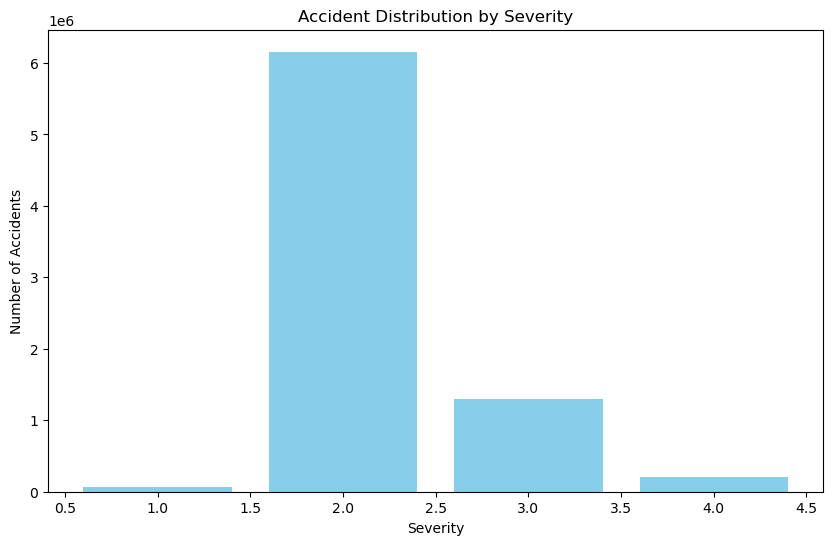

In [66]:
#a. Accident Distribution by Severity

import matplotlib.pyplot as plt

# Convert to Pandas DataFrame
df_pd = df_spark_processed.groupBy("Severity").count().toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_pd['Severity'], df_pd['count'], color='skyblue')
plt.xlabel('Severity')
plt.ylabel('Number of Accidents')
plt.title('Accident Distribution by Severity')
plt.show()


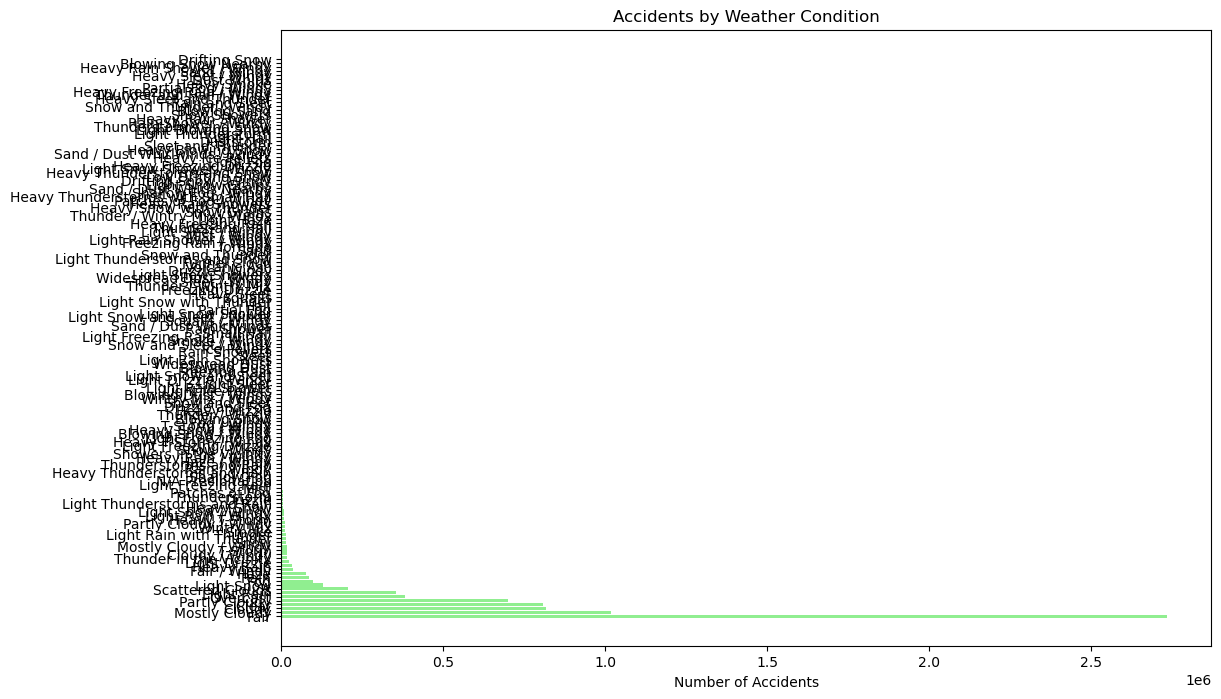

In [67]:
#b. Accidents by Weather Condition
# Convert to Pandas DataFrame
df_weather_pd = df_spark_processed.groupBy("Weather_Condition").count().orderBy("count", ascending=False).toPandas()

# Plot
plt.figure(figsize=(12, 8))
plt.barh(df_weather_pd['Weather_Condition'], df_weather_pd['count'], color='lightgreen')
plt.xlabel('Number of Accidents')
plt.title('Accidents by Weather Condition')
plt.show()


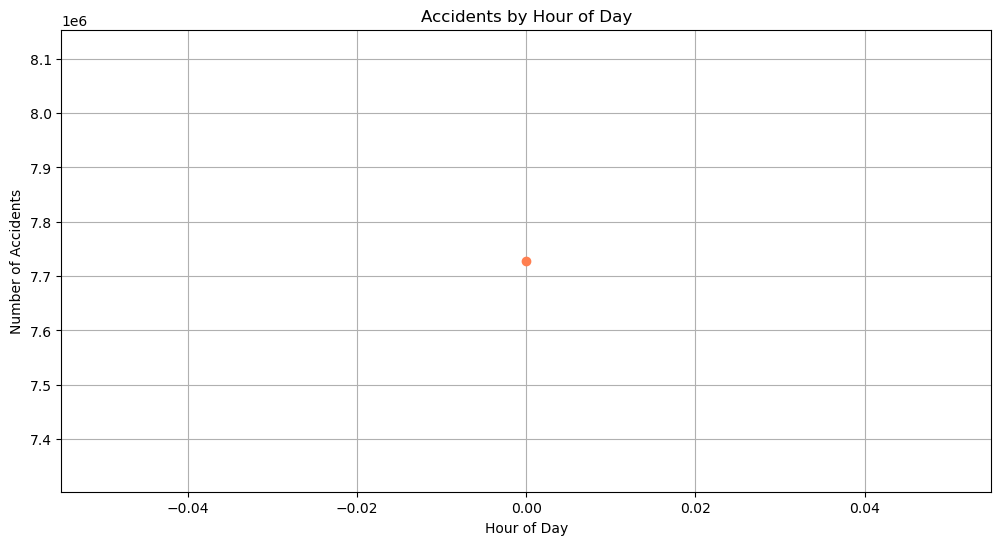

In [68]:
#c. Accidents by Hour of Day
# Convert to Pandas DataFrame
df_hour_pd = df_spark_processed.groupBy("Hour").count().orderBy("Hour").toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_hour_pd['Hour'], df_hour_pd['count'], marker='o', linestyle='-', color='coral')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Hour of Day')
plt.grid(True)
plt.show()



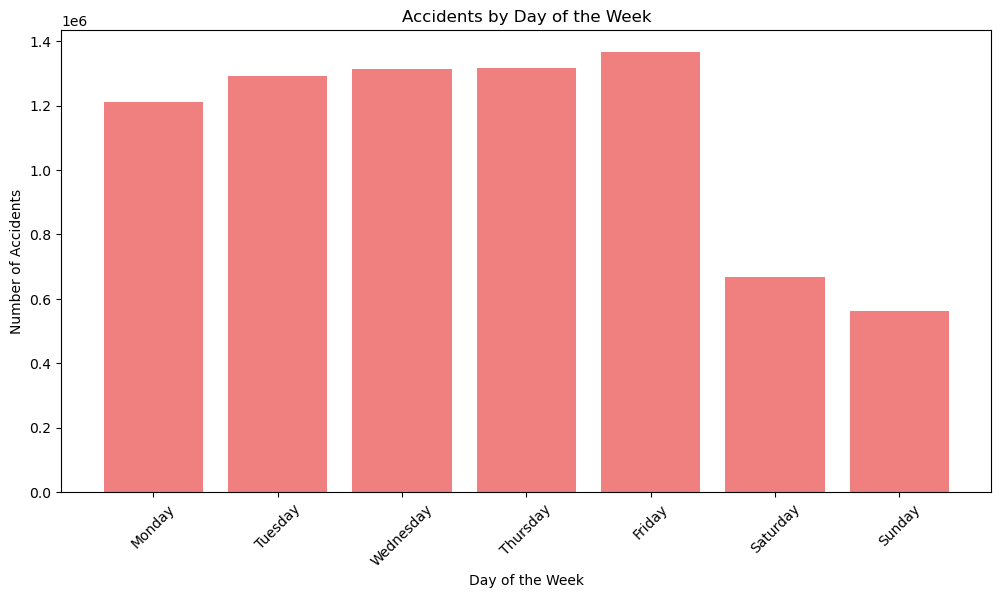

In [69]:
#Understand which days of the week are more prone to accidents.

import matplotlib.pyplot as plt
import pandas as pd

# Extract the day of the week from 'Start_Time'
df_spark_processed = df_spark_processed.withColumn("Day_of_Week", F.date_format(F.col("Start_Time"), 'EEEE'))

# Count accidents by day of the week
day_counts = df_spark_processed.groupBy("Day_of_Week").count().toPandas()

# Define the correct order for days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Ensure days are ordered correctly
day_counts['Day_of_Week'] = pd.Categorical(day_counts['Day_of_Week'], categories=day_order, ordered=True)
day_counts = day_counts.sort_values('Day_of_Week')

# Plot
plt.figure(figsize=(12, 6))
plt.bar(day_counts["Day_of_Week"], day_counts["count"], color='lightcoral')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Day of the Week')
plt.xticks(rotation=45)
plt.show()



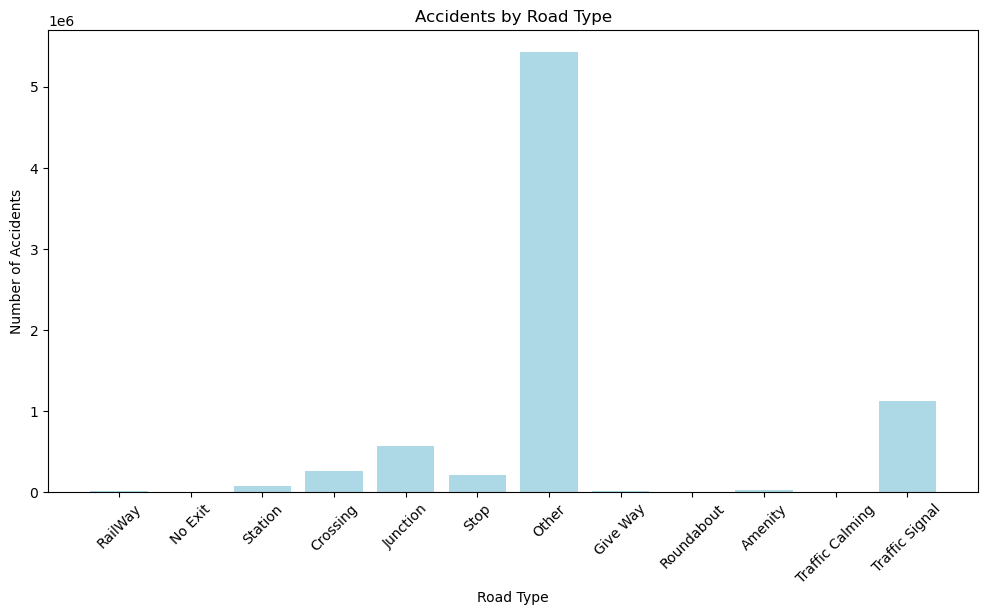

In [84]:
# Accidents by Road Type -Visualize how different road types (e.g., junctions, roundabouts, traffic signals) contribute to accidents.
import matplotlib.pyplot as plt

# Combine features into 'Road_Type' category
df_spark_processed = df_spark_processed.withColumn("Road_Type", 
    F.when(F.col("Junction") == 1, "Junction")
    .when(F.col("Roundabout") == 1, "Roundabout")
    .when(F.col("Stop") == 1, "Stop")
    .when(F.col("Traffic_Signal") == 1, "Traffic Signal")
    .when(F.col("Crossing") == 1, "Crossing") 
    .when(F.col("Station") == 1, "Station")
    .when(F.col("Stop") == 1, "Stop")
    .when(F.col("Railway") == 1, "RailWay")
    .when(F.col("Amenity") == 1, "Amenity")
    .when(F.col("No_Exit") == 1, "No Exit")
    .when(F.col("Give_Way") == 1, "Give Way")
    .when(F.col("Traffic_Calming") == 1, "Traffic Calming")
    .when(F.col("Turning_Loop") == 1, "Turning Loop")
    .when(F.col("Bump") == 1, "Bump")
    .otherwise("Other"))

# Count accidents by road type
road_type_counts = df_spark_processed.groupBy("Road_Type").count().toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(road_type_counts["Road_Type"], road_type_counts["count"], color='lightblue')
plt.xlabel('Road Type')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Road Type')
plt.xticks(rotation=45)
plt.show()


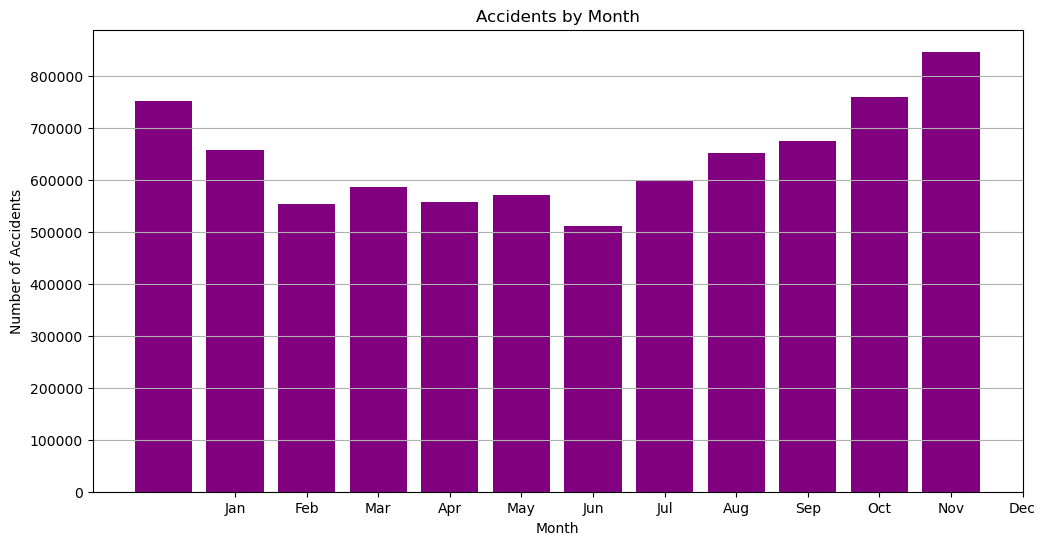

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract month from 'Start_Time'
df_spark_processed = df_spark_processed.withColumn("Month", F.month(F.col("Start_Time")))

# Count accidents by month
monthly_counts = df_spark_processed.groupBy("Month").count().toPandas()

# Define month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Ensure months are ordered correctly
monthly_counts['Month'] = pd.Categorical(monthly_counts['Month'], categories=range(1, 13), ordered=True)
monthly_counts = monthly_counts.sort_values('Month')

# Plot
plt.figure(figsize=(12, 6))
plt.bar(monthly_counts["Month"].astype(str), monthly_counts["count"], color='purple')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.title('Accidents by Month')
plt.xticks(ticks=range(1, 13), labels=month_names)
plt.grid(axis='y')
plt.show()


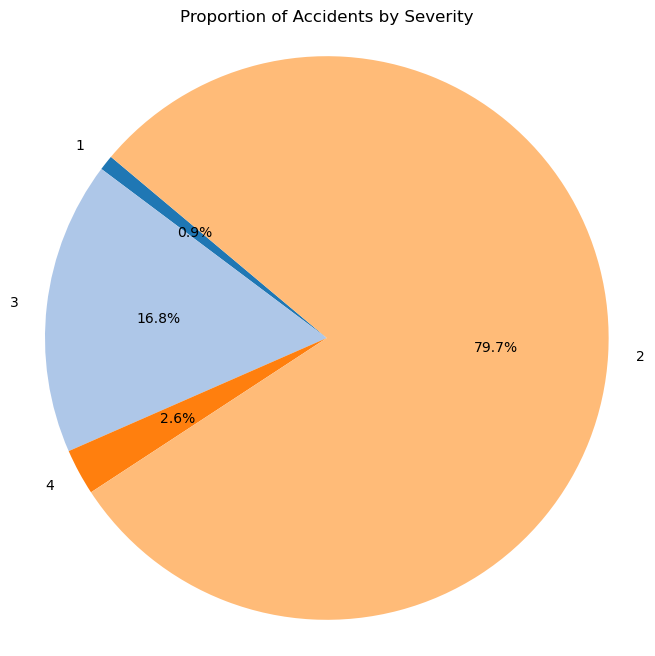

In [72]:
#Display Severity Proportion by Pie Chart

import matplotlib.pyplot as plt

# Count accidents by severity
severity_counts = df_spark_processed.groupBy("Severity").count().toPandas()

# Prepare data for pie chart
labels = severity_counts["Severity"].astype(str)  # Convert to string for labeling
sizes = severity_counts["count"]
colors = plt.get_cmap('tab20').colors  # Use a color map for better colors

# Plot
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Accidents by Severity')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


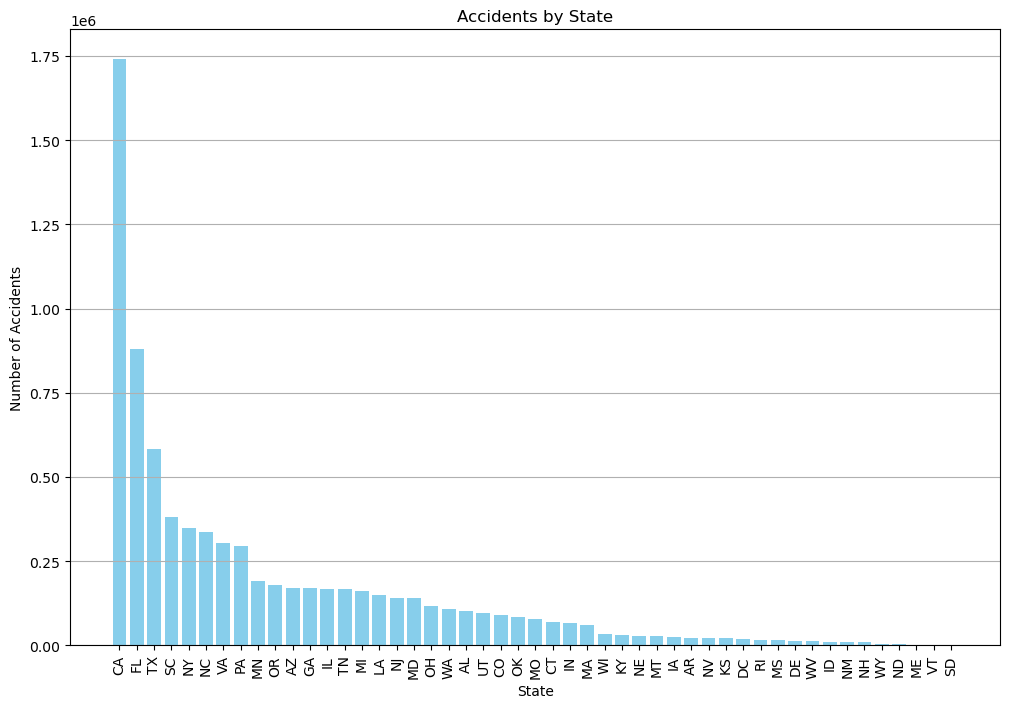

In [73]:
#Accident by state
import matplotlib.pyplot as plt

# Count accidents by state
state_counts = df_spark_processed.groupBy("State").count().toPandas()

# Sort states by the number of accidents (optional)
state_counts = state_counts.sort_values("count", ascending=False)

# Plot
plt.figure(figsize=(12, 8))
plt.bar(state_counts["State"], state_counts["count"], color='skyblue')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.title('Accidents by State')
plt.xticks(rotation=90)  # Rotate state labels for better readability
plt.grid(axis='y')
plt.show()


In [74]:
from pyspark.sql.types import IntegerType, DoubleType, FloatType

# Get a list of all numerical columns
numerical_columns = [field.name for field in df_spark_processed.schema.fields
                     if isinstance(field.dataType, (IntegerType, DoubleType, FloatType))]

print("Numerical columns:", numerical_columns)


Numerical columns: ['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Hour', 'Duration', 'Month']


In [76]:
print('Data overview')
df_spark.printSchema()
print('Columns Overview')
pd.DataFrame(df_spark_processed.dtypes, columns=['Columen Name','Data Type'])

Data overview
root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: date (nullable = true)
 |-- End_Time: date (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = false)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = false)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = false)
 |-- Wind_Chill(F): double (nullable = false)
 |-- Humidity(%): double (nullable = false)
 |-- Pressure(in): double (nullable = false)
 |-- Visibility(mi): double (nullable = false)
 |-- Wind_Direction: string

,Columen Name,Data Type
0,ID,string
1,Source,string
2,Severity,int
3,Start_Time,date
4,End_Time,date
5,Start_Lat,double
6,Start_Lng,double
7,Distance(mi),double
8,Description,string
9,Street,string


C:\Users\HP\AppData\Local\Temp\ipykernel_13824\1705113769.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Road_Type", y="count", data=road_type_accidents_pd, palette="viridis")


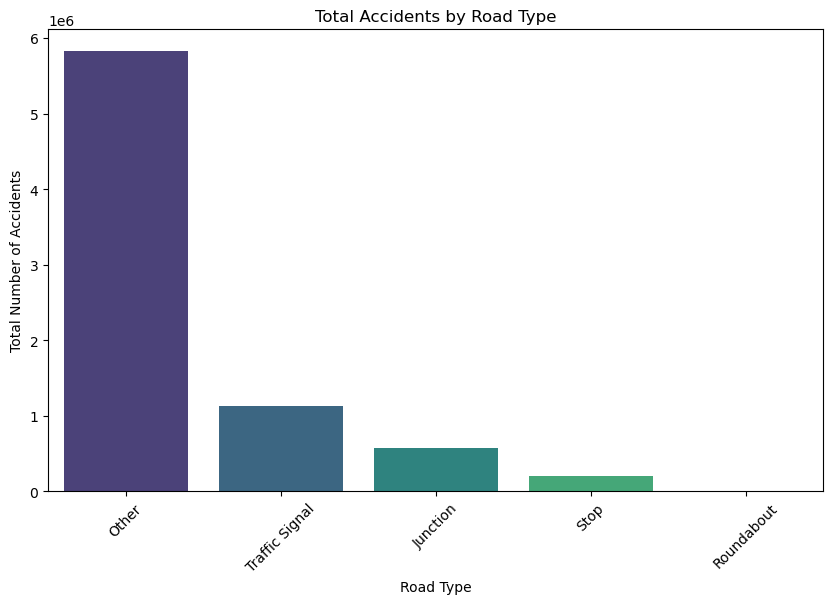

In [79]:
# Group by RoadType and count the number of accidents
road_type_accidents = df_spark_processed.groupBy("Road_Type").count()

# Exclude "Other" if needed
#road_type_accidents = road_type_accidents.filter(road_type_accidents.Road_Type != "Other")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for plotting
road_type_accidents_pd = road_type_accidents.toPandas()

# Sort values for better visualization
road_type_accidents_pd = road_type_accidents_pd.sort_values(by="count", ascending=False)

# Plot using Seaborn or Matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x="Road_Type", y="count", data=road_type_accidents_pd, palette="viridis")
plt.title("Total Accidents by Road Type")
plt.xlabel("Road Type")
plt.ylabel("Total Number of Accidents")
plt.xticks(rotation=45)
plt.show()


In [21]:
#spark.stop()  # Ensure to stop any existing Spark session


In [45]:
import os
from py4j.java_gateway import java_import

# Import Java classes
java_import(spark._jvm, 'org.apache.hadoop.fs.FileSystem')
java_import(spark._jvm, 'org.apache.hadoop.conf.Configuration')

# Set Hadoop configuration
conf = spark._jsc.hadoopConfiguration()
fs = spark._jvm.FileSystem.get(conf)
path = spark._jvm.org.apache.hadoop.fs.Path('C:/US_Accident_processed/processed_data')

# Create directory with permissions if it does not exist
if not fs.exists(path):
    fs.mkdirs(path)



In [ ]:
df_spark_processed.write.csv('C:/US_Accident_processed/processed_data.csv')


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ExportDataToPostgreSQL") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Define PostgreSQL JDBC properties
jdbc_url = "jdbc:postgresql://localhost:5432/postgres" 
jdbc_driver = "org.postgresql.Driver"
jdbc_user = "postgres"  
jdbc_password = "admin"  


processed_us_accident = spark.read.csv("C:/US_Accident_processed/processed_data.csv")  # Replace with your DataFrame source

# Write DataFrame to PostgreSQL
processed_us_accident.write \
    .jdbc(url=jdbc_url, table="us_accident_data_PG", mode="overwrite", properties={
        "driver": jdbc_driver,
        "user": jdbc_user,
        "password": jdbc_password
    })

# Stop the Spark session
spark.stop()
